In [3]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


In [10]:
df = pd.read_csv("C:/Users/tiuyy/Downloads/archive (2)/mercari_train.tsv", sep = '\t')

In [11]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [12]:
df.isnull()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...
1482530,False,False,False,False,False,False,False,False
1482531,False,False,False,False,False,False,False,False
1482532,False,False,False,False,True,False,False,False
1482533,False,False,False,False,True,False,False,False


In [13]:
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [14]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape

((1185854, 8), (296681, 8))

Text(0.5, 1.0, 'Price Distribution')

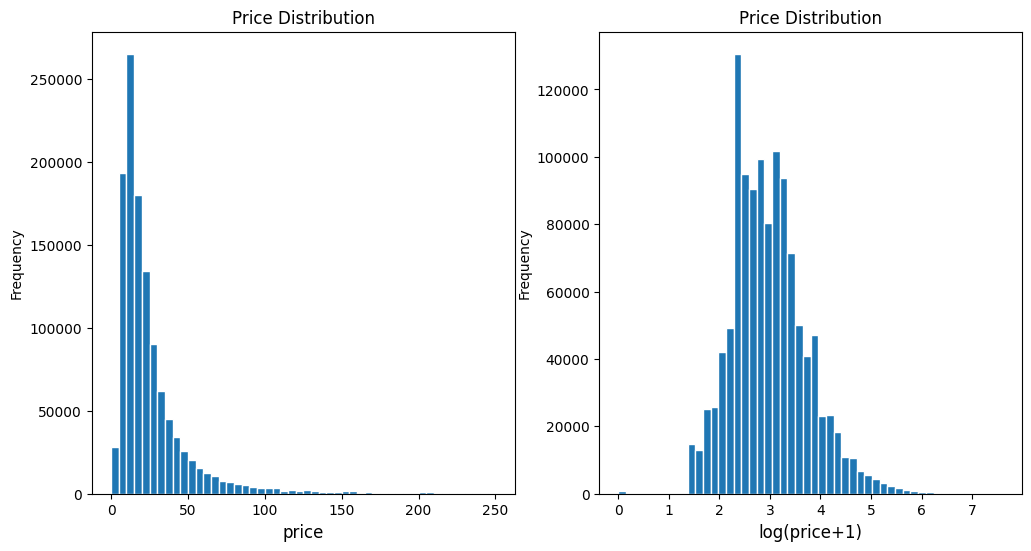

In [15]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [16]:
#Over 55% of items shipping fee were paid by the buyers.
train['shipping'].value_counts() / len(train)

shipping
0    0.552851
1    0.447149
Name: count, dtype: float64

In [17]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.55 if seller pays shipping
The average price is 30.11 if buyer pays shipping


In [18]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1267 unique values in category name column


C:\Users\tiuyy\AppData\Local\Temp\ipykernel_1668\3971742956.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))


<Axes: xlabel='item_condition_id', ylabel='price'>

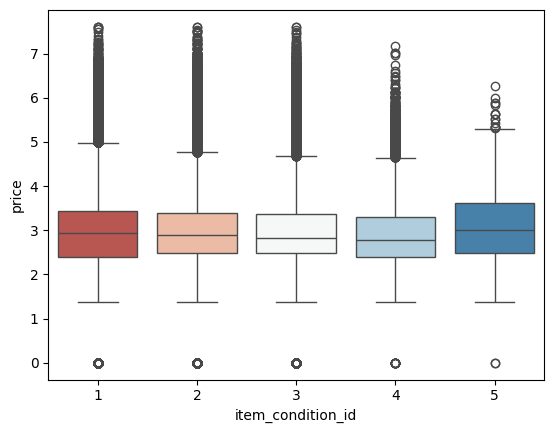

In [19]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [20]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [21]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [22]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [23]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [25]:
df = pd.read_csv('C:/Users/tiuyy/Downloads/archive (2)/mercari_train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [26]:
#Merging train and test data
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])


In [27]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

C:\Users\tiuyy\AppData\Local\Temp\ipykernel_1668\3072605587.py:4: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  dataset['item_description'].replace('No description yet,''missing', inplace=True)


In [28]:
#Count vectorize name and category name columns.
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [29]:
#TF-IDF Vectorize item_description column.
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [30]:
#Label binarize brand_name column.
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name']) 

In [31]:
#Create dummy variables for item_condition_id and shipping columns.
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

C:\Users\tiuyy\AppData\Local\Temp\ipykernel_1668\1079250727.py:2: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)


In [32]:
#Create sparse merge.
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [33]:
#Remove features with document frequency <=1.
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [34]:
#Separate train and test data from sparse merge.
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [35]:
train_X = lgb.Dataset(X, label=y)

In [36]:

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'device': 'gpu',  # Specify 'gpu' for GPU usage
        'gpu_platform_id': 0,  # Specify the platform ID of the GPU (if needed)
        'gpu_device_id': 0
    }

In [37]:
callbacks = [lgb.callback.log_evaluation(period=100)]

# Train the model
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, callbacks=callbacks)

In [38]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 2.118412756890347
